In [9]:
import tensorflow as tf
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [15]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()

In [16]:
len(train_labels), len(test_labels)

(60000, 10000)

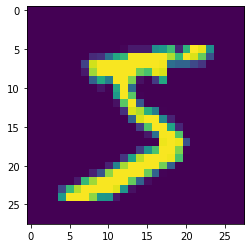

5


In [17]:
plt.imshow(train_images[0, :, :])
plt.show()
print(train_labels[0])

Приводим numpy массивы к torch тензорам

In [18]:
X_train = torch.from_numpy(train_images)
y_train = torch.from_numpy(train_labels)
X_test = torch.from_numpy(test_images)
y_test = torch.from_numpy(test_labels)

В конволюционную сеть хотим передавать картинку в виде 3-мерного тензора. В данном случае 1 канал, так что 'разжимаем' картинку до размера 1х28х28

In [19]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [20]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [21]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        # растяжение тензора
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [23]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [24]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

tensor(0.9752)
tensor(0.9828)
tensor(0.9855)
tensor(0.9856)
tensor(0.9887)
tensor(0.9870)
tensor(0.9884)
tensor(0.9893)
tensor(0.9871)
tensor(0.9882)
tensor(0.9856)
tensor(0.9900)
tensor(0.9900)
tensor(0.9887)
tensor(0.9890)
tensor(0.9897)


KeyboardInterrupt: ignored

In [25]:
lenet5.forward(X_test)

tensor([[-2.1689, -0.4536, -0.5034,  ..., 15.1323, -2.3992,  4.2093],
        [ 0.5750,  0.7921, 16.4131,  ..., -2.6729,  1.9181, -3.1374],
        [-3.1475, 18.6748, -1.8894,  ...,  1.7557,  0.3321, -1.9060],
        ...,
        [-5.2977, -1.1946, -3.8438,  ...,  1.6023,  0.7072,  2.8882],
        [-0.4608, -2.4385, -7.8854,  ..., -6.2615,  5.4349, -2.7379],
        [ 2.6123, -5.1966, -1.0496,  ..., -8.8218, -1.8476, -3.7696]],
       grad_fn=<AddmmBackward0>)

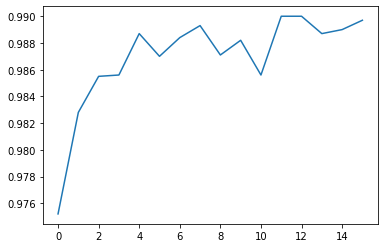

In [26]:
plt.plot(test_accuracy_history)

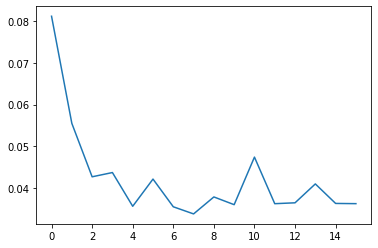

In [27]:
plt.plot(test_loss_history)

Улучшаем модель до результата >=0.992

In [85]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.LeakyReLU(0.005)
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.LeakyReLU(0.005)

        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        # растяжение тензора
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [86]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [87]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-4)

In [88]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

tensor(0.9538)
tensor(0.9712)
tensor(0.9747)
tensor(0.9793)
tensor(0.9793)
tensor(0.9830)
tensor(0.9832)
tensor(0.9850)
tensor(0.9827)
tensor(0.9846)
tensor(0.9843)
tensor(0.9853)
tensor(0.9866)
tensor(0.9847)
tensor(0.9872)
tensor(0.9862)
tensor(0.9876)
tensor(0.9866)
tensor(0.9875)
tensor(0.9888)
tensor(0.9860)
tensor(0.9879)
tensor(0.9883)
tensor(0.9844)
tensor(0.9860)
tensor(0.9885)
tensor(0.9886)
tensor(0.9887)
tensor(0.9867)
tensor(0.9871)
tensor(0.9873)
tensor(0.9881)
tensor(0.9900)
tensor(0.9892)


KeyboardInterrupt: ignored

In [ ]:
plt.plot(test_accuracy_history)

In [ ]:
plt.plot(test_loss_history)